# Analyzing New York City (NYC) High School Data

## 1. Introduction

In this project we are going to analyze `SAT (Scholastic Aptitude Test)` along with the `demographics` of each New York City High Schools. *SAT* is a test that high school seniors take every year in the US. It has three sections, each is worth 800 points. Colleges use the SAT scores to determine which student to admit. In the US educational system efficacy of these standardized tests are controversial. Our objective in this project is to find out if they are unfair to certain groups. New York City has significant immigrant population and is very diverse. So comparing demographic factors such as race, income, and gender with SAT scores is a good way of determining the authenticity of these tests. For e.g. if certain racial groups consistently perform better on the SAT, we can deduce it as unfair.

Link to the NYC data on high school SAT scores is here __[link](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)__

Link to the demographics for each high school is here __[link](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2)__

**Following are the seven data-sets which we need to combine into a single dataset for the analysis:-**

* `SAT scores by school` - SAT scores for each high school in New York City

* `School attendance` - Attendance information for each school in New York City

* `Class size` - Information on class size for each school

* `AP test results` - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)

* `Graduation outcomes` - The percentage of students who graduated and other outcome information

* `Demographics` - Demographic information for each school

* `School survey` - Surveys of parents, teachers, and students at each school

## 2. Building a Single Dataset for Easy Analysis

### 2.1 Read in the CSV Data 

Six of the data we need to analyze are in a single folder called *data_files*. Using *pandas.read_csv()* method we will store them in a dictionary called *data* for the ease of future analysis.

In [1]:
#import all the necessary modules
import pandas as pd
import numpy
import re
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### 2.2 Read in the Surveys Data

We read the *survey data* seperately as they are in the *txt* format unlike others which are in the *csv* format. We will club both the survey datasets *all_survey* and *d75_survey* into a single dataset using *pd.concat()* method. Then we will add this dataset in the *data* dictionary.

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

#change the dbn column case into capital
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]

#Add survey data into the data dictionary
data["survey"] = survey

### 2.3 Adding DBN Columns 

*DBN* represents a *School Identification Code (District Borough Number)*. Close observation of the data shows that the dataset *class_size* does not have a *DBN* column and dataset *hs_directory* has a *dbn* column, which needs to be converted into uppercase. In the *class_size* dataset *DBN* is just a combination of the *CSD* and *SCHOOL CODE* columns. Since the *DBN* is padded, the *CSD* portion of it always consists of two digits. That means we need to add a leading *0* to the *CSD* if the CSD is less than two digits long. We will create a function *pad_csd()* with *number as a parameter*. This function converts the *number* into a string and checks it's length. If the string is two digit long returns the string, if it is one digit long adds *0* in the front and returns it.

In [3]:
#rename the dbn column in the hs_directory
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

#define a function pad_csd()
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
#impliment the above function using Series.apply() method on CSD column
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

#create the new DBN column adding padded_csd and SCHOOL CODE columns
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### 2.4 Converting Columns into Numeric

In the *sat_results* dataset, three columns *SAT Math Avg. Score*, *SAT Critical Reading Avg. Score*, and *SAT Writing Avg. Score* totals up the *SAT scores* for the different sections of the exam. Working with a single number rather than a three makes it easier to correlate scores with demographic factors. These three columns are in *string* format, so we need to convert them into *numeric type* before adding them up. 

Next, we will parse the *latitude* and *longitude* coordinates for each school. This enables us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field *Location 1* in the *hs_directory* dataset. We will create two functions one for returning *latitude* called *find_lat()* & another for finding *longitude* called *find_lon()*. We will use *regular expressions* to pull out the *latitude* and *longitude*, then use string methods *split()* and *replace()* to extract each coordinate. Convert them to *numeric type* using *pd.to_numeric()* method.

In [4]:
#convert the following three column into numeric type using pd.to_numeric() method & add them up
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]


#create find_lat() & find_lon() functions to extract latitude & longitude seperately
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

#using Series.apply() method impliment the above functions & extract the latitudes and longitudes
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

#convert the lat & lon columns into numeric type using pd.to_numeric() method
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### 2.5 Condensing the Datasets

We will seperate the *class_size* dataset from *data* dictionary for further analysis. Since we are only interested in high schools, we need to filter the *GRADE* column by selecting only `09-12` grades. In *PROGRAM TYPE* column `GEN ED` is the largest category, so we will only filter it. The *CORE SUBJECT* column has four subjects *'ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES'*. Each has unique *DBN* values. Using the *df.groupby()* method, we will split this dataframe into four separate groups. Then we will compute the average for the *AVERAGE CLASS SIZE* column in each of the four groups using the *agg()* method. After we are done with the above operations we will include the *class_size* dataset back into *data* dictionary.

In *demographics* dataset we are only interested in the most recent school year. i.e. `20112012`. We will filter this year from the *schoolyear* column. This will also match *SAT* results data.

The *Demographic* and *Cohort* columns in the *graduation* dataset prevent DBN from being unique. A *Cohort* appears to refer to the 'year' the data represents, and the *Demographic* appears to refer to a 'specific demographic group'. We will pick data from the most recent Cohort available, which is *2006*. We also want data from the full cohort, so we'll only pick rows where Demographic is *Total Cohort*.

In [5]:
#from the class_size select grades '09-12' & program type 'GEN ED'
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

#calculate the average DBN value for each subject using Series.groupby().agg() method
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

#select 20112012 schoolyear from the demographics dataset
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

#filter year 2006 from Cohort column & total Cohort from the Demographics column in graduation dataset
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### 2.6 Converting AP Scores to Numeric

*Advanced Placement (AP)* test is an exam high school students take before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn scores *3 and above* (AP exams have 1 to 5 scale) may receive college credit. It will be interesting to find out whether *AP* exam scores are correlated with *SAT* scores across high schools. For this first we need to convert the AP exam scores in the *ap_2010* data set to numeric values.

In [6]:
#convert the columns related to AP exams in ap_2010 dataset to numeric value
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### 2.7 Combining the Datasets

Since we want our final dataframe to have the same *DBN* values as the original *sat_results* dataframe. For this purpose we will use *pandas.dataframe.merge()* method with keyword arguments *how='left'* and *on='DBN'*. First, we'll assign *sat_results* to the variable *combined*. Then, we will merge the other dataframes with combined.

In [7]:
#Create a variable combined with just sat_results from the data then merge
#remaining dataframes

combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

#fill the null values with mean value using df.fillna() method &
#any remaining null value with 0 value
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### 2.8 Adding a School District Column for Mapping

Finally, we are done with cleaning and combining the data. An interesting way of analyzing it is to map the statistics out on a school district level. Adding a column to the data which specifies the school district will help us achieve this. School district is just the first two characters of the *DBN*. We will write a function *get_first_two_chars()* inorder to accomplish this.

In [8]:
#define a function to extract first two characters of DBN 
def get_first_two_chars(dbn):
    return dbn[0:2]

#Apply the above function on DBN columnm & store it in a new column called school_dist
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## 3. Finding Correlations

*Correlations* depicts how closely any two columns are related. We will use *pd.df.corr()* method to find the correlation between different columns in our dataset. The method returns a new dataframe where the index for each column and row is the name of a column in the original dataset.

In [9]:
#create a new dataset correlations with correlation values between the columns
correlations = combined.corr()

#filter just the sat_score in the correlation dataset & print the values
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


**From the above data we make following observations:-**

* The *SAT Critical Reading Avg. Score*, *SAT Math Avg. Score*, *SAT Writing Avg. Score*, and *sat_score* strongly correlate with *sat_score*.
* Column *total_enrollment* has a positive correlation with *sat_score*. This implies that the larger schools do better on SAT in condradiction to assumption that smaller schools where students receive more attention get higher scores. Other similar columns *total_students*, *N_s*, *N_p*, *N_t*, *AP Test Takers*, *Total Exams Taken*, and *NUMBER OF SECTIONS* correlate similarly. 
* Both the percentage of females *female_per* and number of females *female_num* at a school correlate positively with SAT score, whereas the percentage of males *male_per* and the number of males *male_num* correlate negatively. This indicates that girls do better in SAT than boys.
* Teacher and student ratings of school safety *saf_t_11*, and *saf_s_11* correlate with sat_score.
* Student ratings of school academic standards *aca_s_11* correlate positively with *sat_score*, but this does not apply to the ratings from teachers and parents *aca_p_11* and *aca_t_11*.
* There is significant racial inequality in SAT scores, i.e. correlation is highest for *white_per* and then for *asian_per*, both being positive. But *black_per*, *hispanic_per* correlates negatively with the latter being lowest.
* The percentage of English language learners at the school *ell_percent*, *frl_percent* has a strong negative correlation with SAT score.


## 4. Plotting Survey Correlations

We will further analyze different survey fields *(survey_fields)* with *sat_score*. First we will find the correlation between these fields and *sat_score* and then plot them using bar plot. This will give us a clear picture of how the correlation values of these various survey fields varies with *sat_score*. 

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


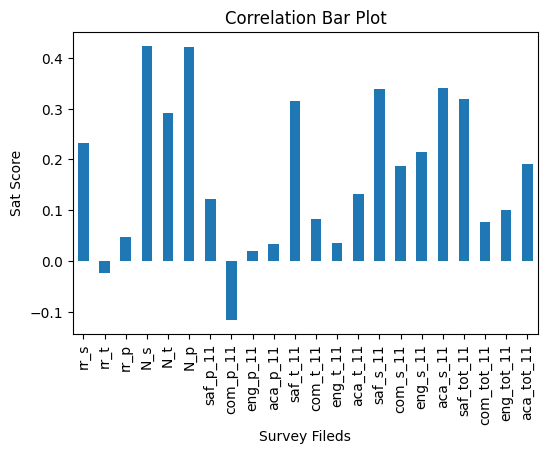

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
print(correlations[survey_fields])

#make a bar plot of correlations between these fields & sat_score
correlations[survey_fields].plot.bar()
plt.xlabel('Survey Fileds')
plt.ylabel('Sat Score')
plt.title('Correlation Bar Plot')
plt.show()

`Above graph depicts the correlation between `**sat_score**` and `**survey_fields**`. Looking at the graph and the correlation values we make following observations:-`

* Except *com_p_11* (communication score based on parent responses) and *rr_t* (teacher response rate) all other survey fileds have positive correlation with *sat_score*.
* Highest of all is *N_s* (number of student respondents) and *N_p* (number of parent respondents) with *~0.42*.
* Next highest are *saf_s_11* (safety and respect score based on student responses) and *aca_s_11* (academic expectations score based on student responses) at *~0.34*.
* The third highest are *saf_t_11* (safety and respect score based on teacher responses) and *saf_tot_11* (safety and respect total score) at *~0.31*.

### 4.1  Exploring Safety and SAT Scores

Above analysis indicates that *saf_s_11* (how students perceive safety) and *saf_tot_11* (total safety) correlation values (verses SAT Scores) are *~0.34* and *~0.31* respectively. In here we will dig deeper into this relationship and figure out which schools have low safety scores.

First we will plot *saf_s_11* vs *sat_score* from the combined dataset.

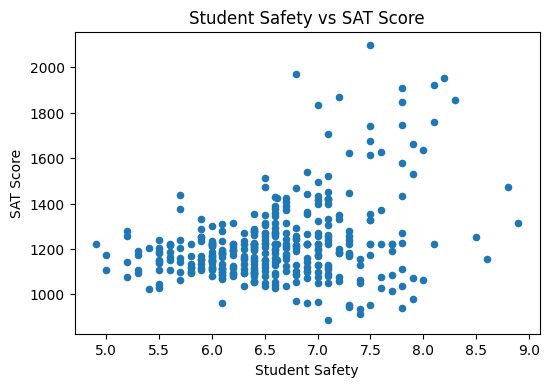

In [11]:
combined.plot.scatter(y = 'sat_score', x = 'saf_s_11')
plt.ylabel('SAT Score')
plt.xlabel('Student Safety')
plt.title("Student Safety vs SAT Score")
plt.show()

From the above scatter plot of *Student Safety vs SAT Score*, we observe that there is a very gradual but steady increase in the SAT score with increase in the Student safety. Even if it does not apply in all the cases, overall increase is aparent. There is an accumulation of data points in the region *5.5 to 7.5* in  students safety and between *1000 & 1500* in SAT Score. These data points show that with the same safety value, SAT scores can be different for different schools indicating that in some cases there is no relation between students safety and SAT score.

Below we will compute the *average Safety Score* (we will take total safety values *saf_tot_11* for this purpose) for each *borough* in the New York city. New York city has been devided into 5 boroughs. These are listed below:-

* Brooklyn
* Manhattan
* Queens
* Staten Island
* The Bronx

Here we have a column *boro* in the dataframe, which has relevant boroughs. Then using *df.pivot_table()* method we will calculate the mean safety values for each borough.

In [12]:
#apply value_counts() method to calculate the number of each borough
combined['boro'].value_counts().sort_values(ascending=False)

Brooklyn         106
Bronx             93
Manhattan         90
Queens            64
Staten Island     10
Name: boro, dtype: int64

In [13]:
#apply df.pivot_table() method to calculate the average safety score for each borough
combined.pivot_table(index='boro', values='saf_tot_11', aggfunc= 'mean')

,saf_tot_11
boro,
Bronx,7.322581
Brooklyn,7.129245
Manhattan,7.473333
Queens,7.387500
Staten Island,7.200000


The above table shows the average safety values for all the five boroughs. Average safety value for each borough is roughly at *~7*.  The highest among them is *Manhattan* with *7.47* of average safety value. Least of them is *Brooklyn* at *7.13*.   

## 5. Exploring Race and SAT Scores

In this section we are going to explore the *SAT Scores* of various *Races*. There are four races listed in the data. These are *Whites*, *Asians*, *Blacks* and *Hispanics*. Below we will look into the correlation values for different races with SAT Score.

In [14]:
#print the correlation value between different races and sat scores
print('whites vs sat score: ', correlations['white_per'])
print('asians vs sat score: ', correlations['asian_per'])
print('blacks vs sat score: ', correlations['black_per'])
print('hispanics vs sat score: ', correlations['hispanic_per'])

whites vs sat score:  0.6207177638526802
asians vs sat score:  0.5707302200214872
blacks vs sat score:  -0.2841394684581478
hispanics vs sat score:  -0.39698493078147196


From the above calculation we observe that there are two negative correlations one for *blacks* and other for *hispanics*. Below we will build a bar plot in order to look at the better picture of correlation value.

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

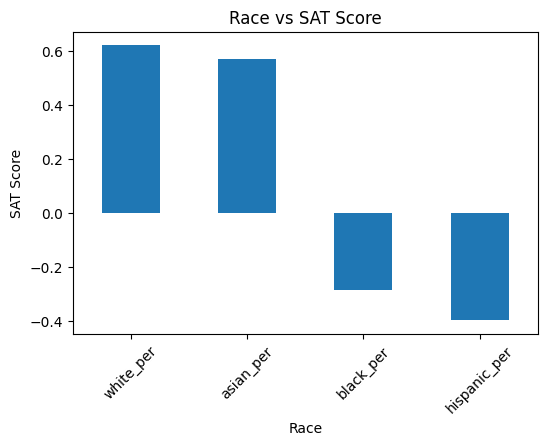

In [15]:
#make a bar plot for all the races with sat score
correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot(x='sat_score', kind='bar')
plt.title('Race vs SAT Score')
plt.ylabel('SAT Score')
plt.xlabel('Race')
plt.xticks(rotation=45)

From the above table it is very clear the difference between correlation value of different races with sat score. First highest is for *whites* at *~ 62%* and second highsest is for *Asians*, slightly lower at *~ 57%*. But for *blacks* and *hispanics*, it is negative at *~ -28%* and *~ -40%* respectively. 

**Below we will explore more about *hispanic percentage and SAT Score*. We want to know the schools with high percentage of hispanics and low SAT Scores. We are going to make a scatter plot for *hispanic_per* and *sat_score*.**

Text(0.5, 1.0, 'Hispanic percentage vs SAT Score')

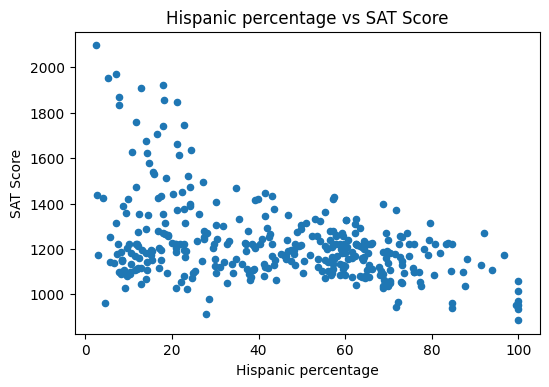

In [16]:
#build a scatter plot for Hispanics vs SAT score
combined.plot.scatter(x='hispanic_per', y='sat_score')
plt.xlabel('Hispanic percentage')
plt.ylabel('SAT Score')
plt.title('Hispanic percentage vs SAT Score')

The negative trend between the *SAT Score* and *Hispanic Percentage* is very clear from the above graph. At schools with low percentage of hispanics the SAT Score is considerably higher. With increase in the percentage of hispanics, SAT Score decreases *exponentially*. Higher the percentage of hispanics lower the SAT Score. 

**Below we will explore the schools with higher hispanics percentage, i.e. above *95%*.**

In [17]:
hispanic_95 = combined[combined['hispanic_per']> 95.0]
hispanic_95[['SCHOOL NAME', 'hispanic_per']]

,SCHOOL NAME,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8
253,MULTICULTURAL HIGH SCHOOL,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0


There are *8* schools in the list which have above *95%* of hispanics. In these schools atleast *80%* of students are economically disadvantaged, in some schools *100%* students are economically disadvantaged. These schools have very low *national rankings* ranging from  *above 1000*  and in some cases even *closer to 10000*. *New York High Schools rankings* is also lower for these schools, in some cases *above 100* and in others *closer to 800*. The minority enrolment in these schools are almost *100%*.

**Below we will explore the schools with percentage of hispanics less than *10%* and average SAT Score greater than *1800*.**

In [18]:
hisp_10 =  combined[(combined['hispanic_per']<10.0) & (combined['sat_score']>1800)]
hisp_10[['SCHOOL NAME', 'sat_score', 'hispanic_per']]

,SCHOOL NAME,sat_score,hispanic_per
37,STUYVESANT HIGH SCHOOL,2096.0,2.4
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,7.2
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,7.9
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,7.9
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,5.3


There are only *5* schools in the list which have less than *10%* of hispanics and more than *1800* SAT Scores. Among these schools minority enrolment is comparatively lesser than the list with high hispanic percentage and lower percentage of economically disadvantaged students highest being *~ 60%*. The national rankings of these schools are very good. Highest being *22* and lowest being *44*. *New York High School Rankings* are also great, all five are within *10*. Among the above two lists one more point to be noted is number of full-time teachers. This number is considerably higher for schools with lower hispanic percentage compared to higher hispanic percentage. 

## 6. Exploring Gender and SAT Scores

There are two columns in the dataframe which indicate the percentage of gender. 

* male_per (male percentage)
* female_per (female percentage)

In here we will investigate the correlation between these two columns and the SAT score. First we will plot the correlation and study the graph.

In [19]:
#print the correlation between sat score and genders
print('male percentage Vs SAT Score: ', correlations['male_per'])
print('female percentage Vs SAT Score: ', correlations['female_per'])

male percentage Vs SAT Score:  -0.11206243686028577
female percentage Vs SAT Score:  0.11210773942203284


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

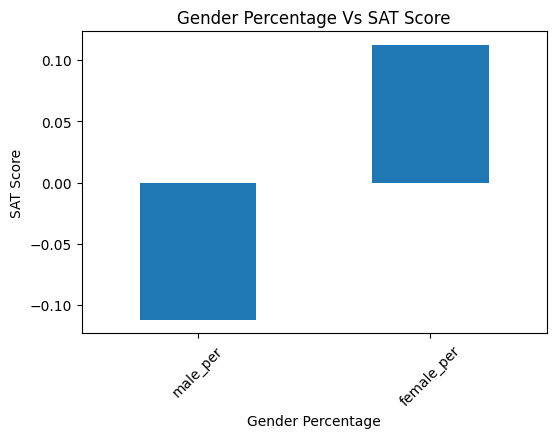

In [20]:
#make a bar plot of gender vs sat score
correlations[['male_per', 'female_per']].plot(x='sat_score', kind='bar')
plt.xlabel('Gender Percentage')
plt.ylabel('SAT Score')
plt.title('Gender Percentage Vs SAT Score')
plt.xticks(rotation=45)

Above analysis shows that the *male percentage* has a negative correlation and *female percentage* has a positive correlation with *SAT score*. The correlation values being *-0.112* and *0.112* for male and female respectively. The contrast is very much evident from the above bar plot. We will further investigate the relation between *SAT scores*, *female percentage* and relevant schools. We will make a scatter plot and observe if there is any pattern between *SAT score* and *female percentage*.

Text(0.5, 1.0, 'Female percentage vs SAT Score')

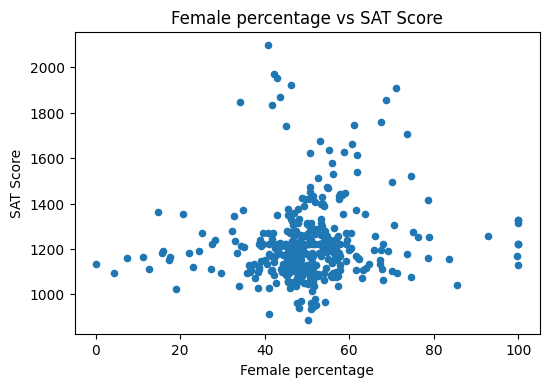

In [21]:
#make a scatter plot of the female percentage and sat score
combined.plot.scatter(x='female_per', y='sat_score')
plt.xlabel('Female percentage')
plt.ylabel('SAT Score')
plt.title('Female percentage vs SAT Score')

There is no clear pattern between the *SAT Score* and *Female percentage*. SAT score is low where the female percentage is either lower (below 40%) and also where the female percentage is higher (above 80%). There is a cluster between 40% and 60%. There are two peaks, one at ~ 40% with SAT score of ~2200 and another at ~ 70% with SAT score of ~ 1900. Further we will explore more about schools with female percentage > 60 and SAT score > 1700.

In [22]:
female_60 = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
female_60[['SCHOOL NAME','sat_score', 'female_per']]

,SCHOOL NAME,sat_score,female_per
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,68.7
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,67.5
60,BEACON HIGH SCHOOL,1744.0,61.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,73.6
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,71.1


There are total 5 schools with female percentage higher than 60 and SAT score more than 1700. In the above list only two of the schools *Townsend Harris High School* (New York High School Ranking is *1*)  and *Eleanor Roosevelt High School* (New York High School Ranking is *11*) have national ranking below *100*. *Bard High School Early College* with very poor national ranking (\~5000) and state ranking (\~400) has an *average SAT score* of *1856* which is impressive.

## 7. Exploring AP Scores and SAT Scores

In here we are going to explore the relationship between *Advanced Placement (AP) scores* and *SAT scores*. It is reasonable to assume that the students who took *AP* exams would be highly correlated with school's *SAT score*. *total_enrollment* column is highly correlated with *sat_score* column, this could lead to a bias. So we will take AP percentage of students by dividing *AP Test Takers* column by *total_enrollment* column. We will plot this new column *ap_per* and *sat_score* and analyze the graph.

In [23]:
#divide AP test takers column by total enrollment and name the new column ap_per
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined['ap_per']

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
         ...   
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 363, dtype: float64

Text(0.5, 1.0, 'AP percentage vs SAT Score')

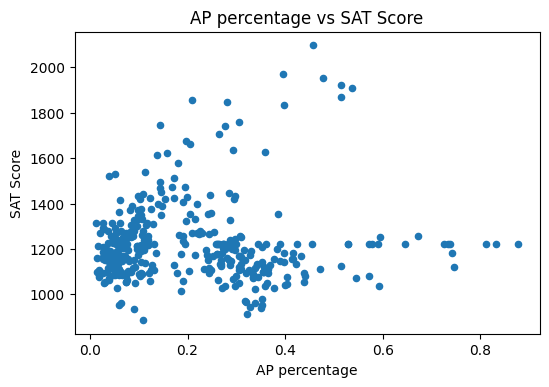

In [24]:
#make a scatter plot of ap_per vs sat_score
combined.plot.scatter(x='ap_per', y='sat_score')
plt.xlabel('AP percentage')
plt.ylabel('SAT Score')
plt.title('AP percentage vs SAT Score')

The graph of *AP percentage* and *SAT score* looks like a C-curve. There are two clusters at the lower left side of the graph. Highest SAT score is recorded with AP percentage between *0.4* and *0.6*. As the AP percentage reduces SAT score also reduces as we can see at the left upper side of the graph. At the lower part of the graph SAT score is more or less same against AP percentage. 

## 8. Exploring Class Size and SAT Scores

In this section we will find more about how *average class size* is related to *SAT score*. Let us look at the correlation value between these two columns.

In [25]:
print("average class size vs sat_score: ",correlations["AVERAGE CLASS SIZE"])

average class size vs sat_score:  0.3810143308095523


There is a moderate correlation between *average class size* and *SAT score*. Further we will build a scatter plot and observe the graph.

Text(0.5, 1.0, 'Average Class Size vs SAT Score')

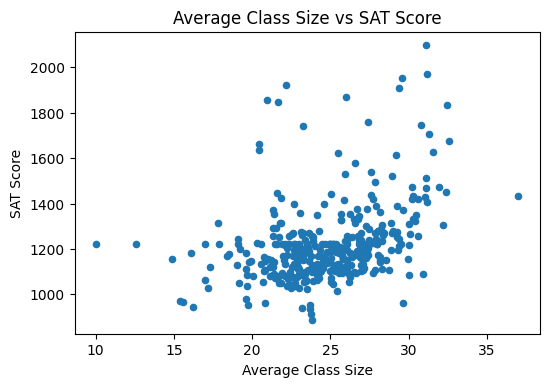

In [26]:
combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score')
plt.xlabel("Average Class Size")
plt.ylabel("SAT Score")
plt.title("Average Class Size vs SAT Score")

The scatter plot shows that there is a steady increase between *SAT Score* and *average class size*. There are clusters between 20 and 30 in the average class size, and between 1000 and 1300 in the SAT Score. Even if the points are scattered around the pattern is very clear. 

## 9. Exploring Least Expensive Neighborhoods and Best Schools

In this section we will look for the least expensive neighborhoods with best schools. For this we need to import a csv datafile containing the details of neighborhoods and house prices. The file link has been given in the *introduction* (demographics for each school). This file was first downloaded into the local computer and then uploaded to the dataquest repository. 

In [27]:
#read the property.csv file using pd.read_csv() method and look at the first few rows
prop_data = pd.read_csv('property.csv')
prop_data.head()

,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority08,priority09,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,NaN,NaN,...,NaN,NaN,NaN,"8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...",14.0,31.0,100802.0,4300730.0,4.157360e+09,Far Rockaway-Bayswater ...
1,21K559,Life Academy High School for Film and Music,Brooklyn,K400,718-333-7750,718-333-7775,9.0,12,NaN,NaN,...,NaN,NaN,NaN,"2630 Benson Avenue\nBrooklyn, NY 11214\n(40.59...",13.0,47.0,306.0,3186454.0,3.068830e+09,Gravesend ...
2,16K393,Frederick Douglass Academy IV Secondary School,Brooklyn,K026,718-574-2820,718-574-2821,9.0,12,NaN,NaN,...,NaN,NaN,NaN,"1014 Lafayette Avenue\nBrooklyn, NY 11221\n(40...",3.0,36.0,291.0,3393805.0,3.016160e+09,Stuyvesant Heights ...
3,08X305,Pablo Neruda Academy,Bronx,X450,718-824-1682,718-824-1663,9.0,12,NaN,NaN,...,NaN,NaN,NaN,"1980 Lafayette Avenue\nBronx, NY 10473\n(40.82...",9.0,18.0,16.0,2022205.0,2.036040e+09,Soundview-Castle Hill-Clason Point-Harding Par...
4,03M485,Fiorello H. LaGuardia High School of Music & A...,Manhattan,M485,212-496-0700,212-724-5748,9.0,12,NaN,NaN,...,NaN,NaN,NaN,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",7.0,6.0,151.0,1030341.0,1.011560e+09,Lincoln Square ...


In [28]:
#rename the *dbn* column name to *DBN* and merge it into the main dataset
prop_data['DBN'] = prop_data['dbn']
prop_data['Price_$'] = prop_data['BIN'] 
prop_data['Neighborhood'] = prop_data['NTA']
combined = combined.merge(prop_data, on="DBN", how="inner")

In the dataset *prop_data* the property prices are listed in the column *Price_$*. First we will check the minimum and maximum property values.

In [29]:
#minimum value
combined['Price_$'].min()

1000811.0

In [30]:
#maximum value
combined['Price_$'].max()

5149609.0

As we can see above, minimum value of properties is little above *\$1000000*. We will check for schools with *sat_score greater than 1700* and *Price_$ less than 1090000* in order to find the cheaper neighborhoods with best schools.

In [31]:
best_school = combined[(combined['sat_score'] > 1700) & (combined['Price_$'] < 1090000)]
best_school[['Neighborhood', 'Price_$', 'SCHOOL NAME', 'sat_score']]

,Neighborhood,Price_$,SCHOOL NAME,sat_score
5,Lower East Side ...,1004062.0,BARD HIGH SCHOOL EARLY COLLEGE,1856.0
26,Lenox Hill-Roosevelt Island ...,1045949.0,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0
37,Battery Park City-Lower Manhattan ...,1084587.0,STUYVESANT HIGH SCHOOL,2096.0
60,Lincoln Square ...,1030328.0,BEACON HIGH SCHOOL,1744.0
61,Lincoln Square ...,1030341.0,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0
79,Manhattanville ...,1084085.0,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",1847.0


We have *six* neighborhoods with best schools and least expensive house prices. The details are in the list above. 

## 10. Exploring the Differences in the Survey Responses Between Parent, Teacher and Student

In here we will investigate the differences in responses to various surveys between parents, teachers and students. Let us look at the *survey* dataset and figure out which are the related columns.

In [32]:
data['survey'].columns

Index(['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11',
       'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11',
       'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11',
       'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11'],
      dtype='object')

Here *rr_t*, *rr_p* and *rr_s* stands for *response rate* for *t-teacher*, *p-parent* and *s-student* respectively. First we will plot the histogram of these three columns and study the response rate for these.

Text(0, 100, 'Student Response Rate')

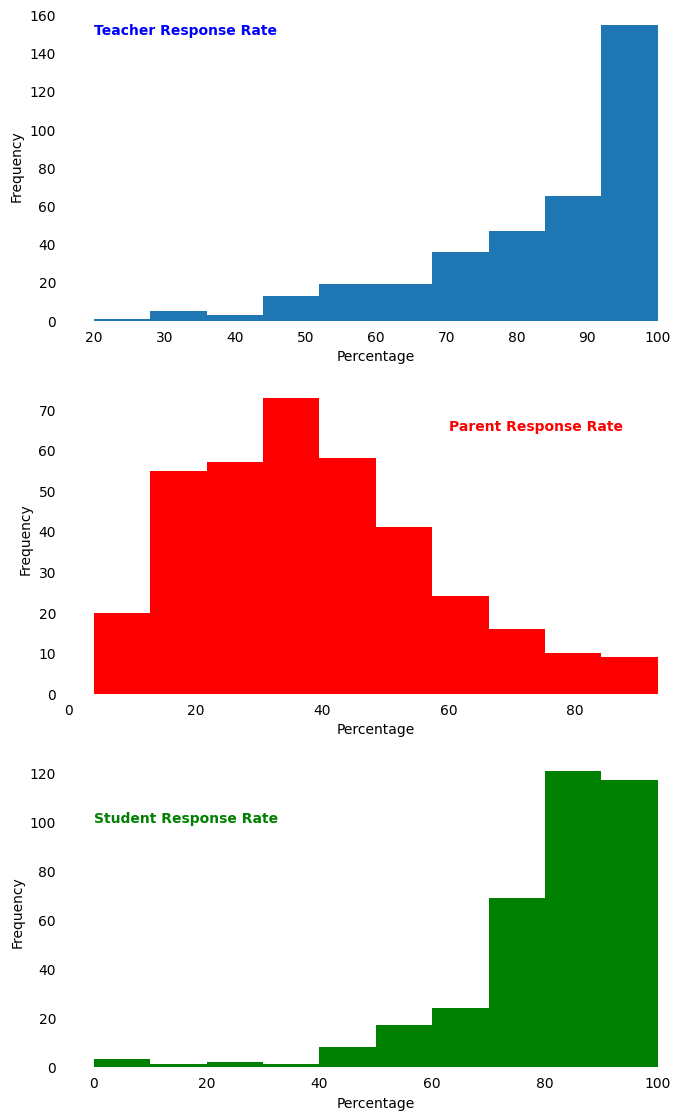

In [33]:
import matplotlib.style as style

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(8, 14))
axes=[ax1, ax2, ax3]
for ax in axes:
    ax.set_xlabel('Percentage')
    ax.tick_params(left=0, bottom=0)
    for location in ['left', 'right', 'bottom', 'top']:
        ax.spines[location].set_visible(False)
combined['rr_t'].plot.hist(ax=axes[0])
combined['rr_p'].plot.hist(ax=axes[1], color='red')
combined['rr_s'].plot.hist(ax=axes[2], color='green')

ax1.text(20, 150, 'Teacher Response Rate', weight='bold', color='blue')
ax2.text(60, 65, 'Parent Response Rate', weight='bold', color='red')
ax3.text(0, 100, 'Student Response Rate', weight='bold', color='green')

Histogram plotted for response rate columns show the differences among the teacher, parent and student response rate to surveys. From the graph we can observe that for teachers and students histogram follows skew symmetry(right). Counts are higher above 90% and gradually decreases with decrease in percentage. Whereas for parents the histogram follows more or less symmetric curve (bell curve) with highest count at around 30% to 40% with counts decreasing both the sides but more gradual on the right side. This indicates that in most of the schools, teacher and student response is better (with 100% response rate)  than the parent (with below 50% response rate) to surveys. 

**Below we will plot the different survey results corresponding to teachers, parents and students.**

Text(0.5, 1.0, 'Student')

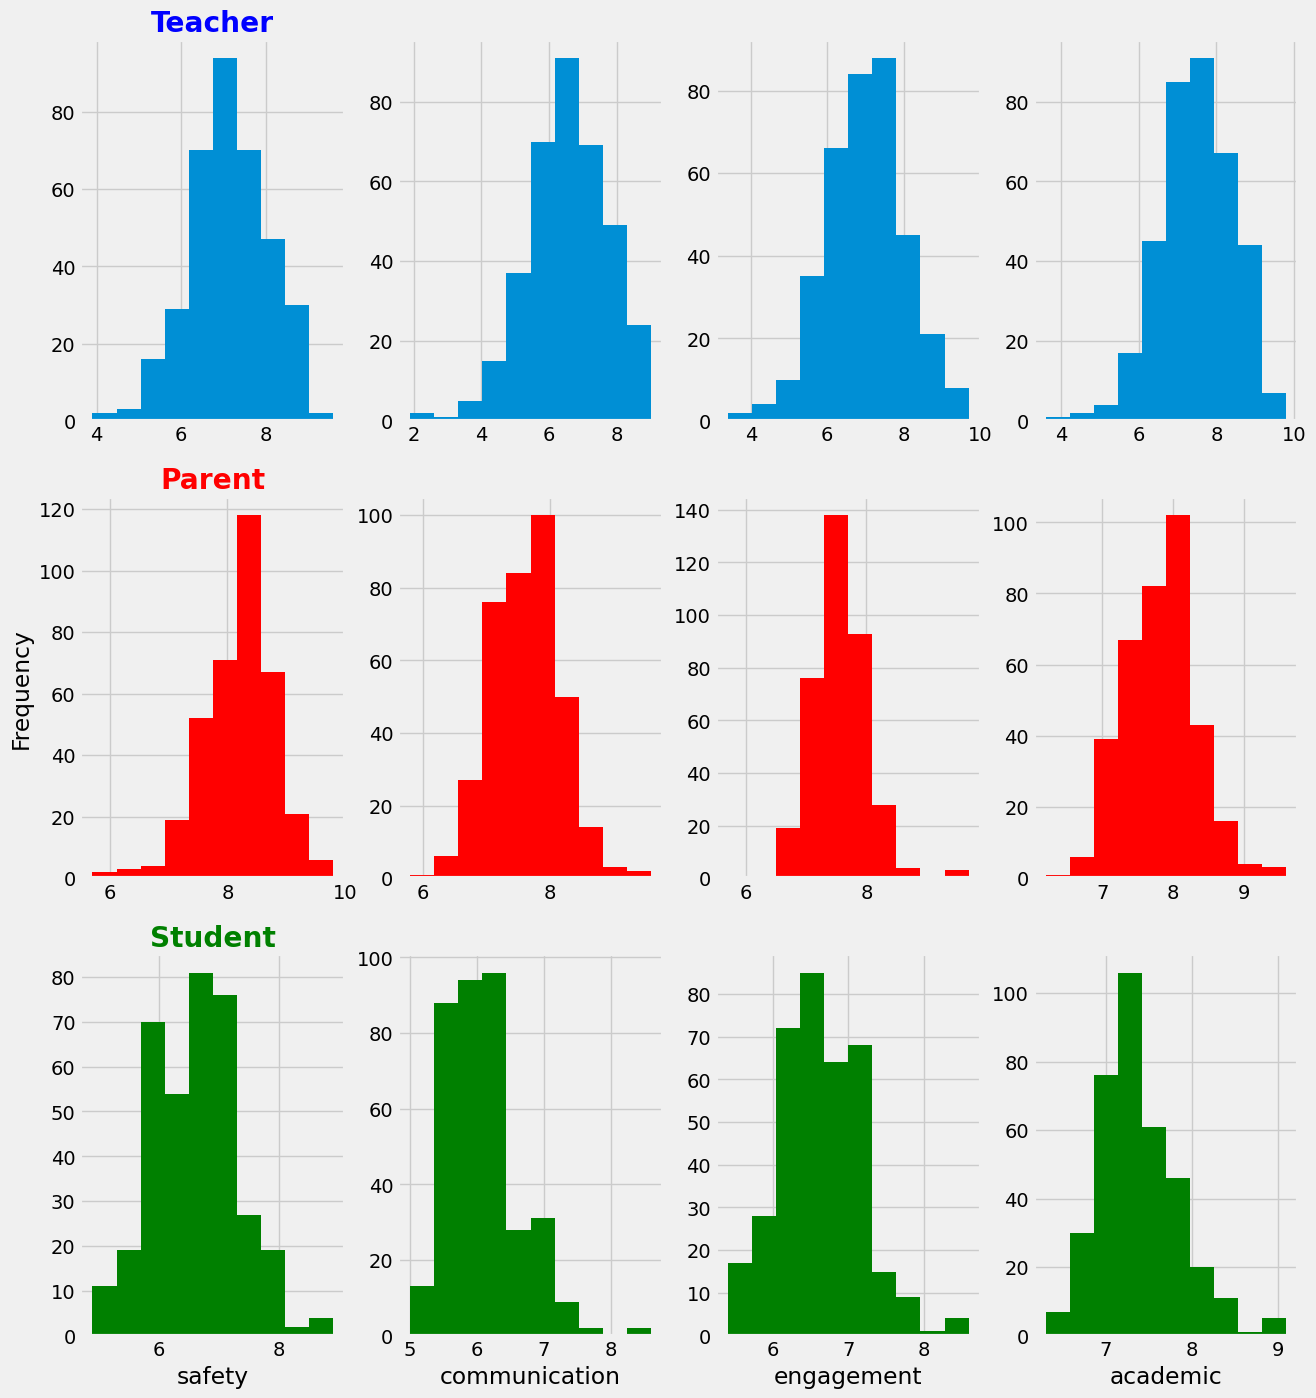

In [34]:
style.use('fivethirtyeight')
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(14, 16))
axs[0,0].hist(combined['saf_t_11'])
axs[0,1].hist(combined['com_t_11'])
axs[0,2].hist(combined['eng_t_11'])
axs[0,3].hist(combined['aca_t_11'])
axs[1,0].hist(combined['saf_p_11'], color='red')
axs[1,1].hist(combined['com_p_11'], color='red')
axs[1,2].hist(combined['eng_p_11'], color='red')
axs[1,3].hist(combined['aca_p_11'], color='red')
axs[2,0].hist(combined['saf_s_11'], color='green')
axs[2,1].hist(combined['com_s_11'], color='green')
axs[2,2].hist(combined['eng_s_11'], color='green')
axs[2,3].hist(combined['aca_s_11'], color='green')
axs[2,0].set_xlabel('safety')
axs[2,1].set_xlabel('communication')
axs[2,2].set_xlabel('engagement')
axs[2,3].set_xlabel('academic')
# axs[0,0].set_ylabel('frequency')
axs[1,0].set_ylabel('Frequency')
# axs[2,0].set_ylabel('frequency')
axs[0,0].set_title('Teacher', weight='bold', color='blue')
axs[1,0].set_title('Parent',weight='bold', color='red')
axs[2,0].set_title('Student',weight='bold', color='green')

In the above graph, first row, second row and third row represents *teacher*, *parent* and *student* surveys respectively. Whereas first, second, third and fourth column represents *safety*, *communication*, *engagement* and *academic expectation* surveys scores respectively. These surveys are ranked from 0 to 10. Below we will just mention the highest number of scores (frequency) marked by the teachers, parents and students. We can understand more about the distribution of these scores looking at the above graph. 

**Safety Score**- From the above graph we observe that highest number of teachers have marked safety score at 7, most parents have marked it at above 8 and most number of students marked safety in between 6 and 7. 

**Communication Score**- Highest number of teachers marked communication score at 7. Most parents have marked it at 8 and highest number students have marked communication at ~ 6. 

**Engagement Score**- Highest number of teachers marked engagement score at ~7. Parents have also marked it at ~7 and students have marked between 6 and 7.

**Academic Expectation Score**- Highest number of teachers and parents have marked academic expectation score at 8. Students have marked at 7.5.

**Below we will calculate the *average score* of each category(among surveys) for teacher, parent and student. Make a plot and compare the results looking at the graph.**


Text(0, 0.5, 'Avg-Response Rate')

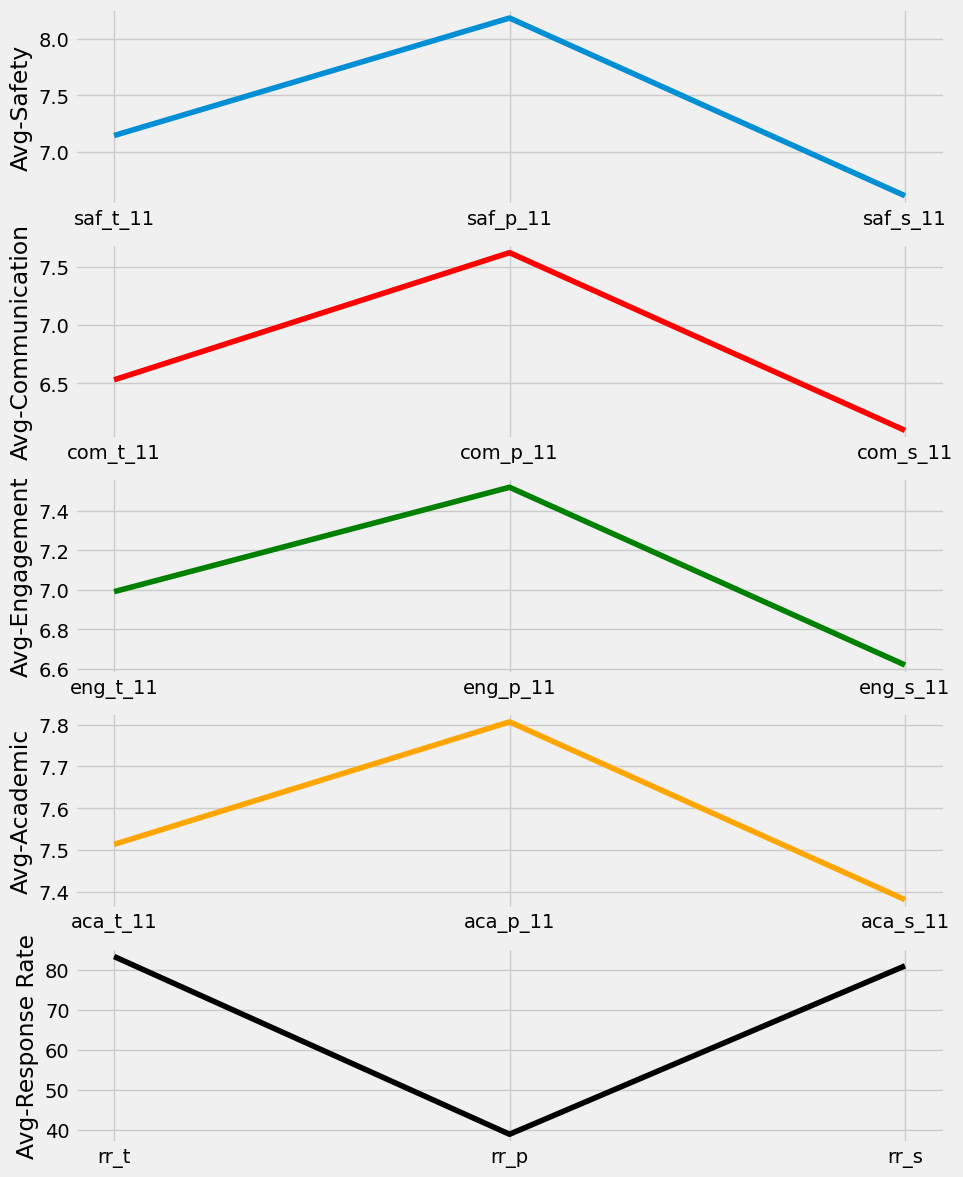

In [35]:
#calculate the mean value for each category among surveys
mean_rr = combined[['rr_t', 'rr_p', 'rr_s']].mean()
mean_safety = combined[['saf_t_11', 'saf_p_11', 'saf_s_11']].mean()
mean_com = combined[['com_t_11', 'com_p_11', 'com_s_11']].mean()
mean_eng = combined[['eng_t_11', 'eng_p_11', 'eng_s_11']].mean()
mean_acad = combined[['aca_t_11', 'aca_p_11', 'aca_s_11']].mean()

#plot the above mean values  
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 14))

axs[0].plot(mean_safety)
axs[1].plot(mean_com, color='red')
axs[2].plot(mean_eng, color='green')
axs[3].plot(mean_acad, color='orange')
axs[0].set_ylabel('Avg-Safety')
axs[1].set_ylabel('Avg-Communication')
axs[2].set_ylabel('Avg-Engagement')
axs[3].set_ylabel('Avg-Academic')
axs[4].plot(mean_rr, color='black')
axs[4].set_ylabel('Avg-Response Rate')

From the above graph we observe that *average survey scores* for all the surveys is highest among parents. Second highest is teachers and the least is of students. But the *average response rate* for the surveys is lowest among parents in contrast with the different survey results.

## 11. Assigning Scores to Schools Based on SAT Score and Other Attributes

In this section we will assign scores to schools based on *SAT Score*, *Total Safety* (both in ascending order), and *Property Price* (in descending order). We will use *df.sort_values()* method for this purpose. 

In [36]:
#create a new dataframe by sorting the appropriate columns
sort_sat = combined.sort_values(by=['sat_score', 'saf_tot_11', 'Price_$'], ascending=[False, False, True], ignore_index=True)
#set the index to begin with 1
sort_sat.index = sort_sat.index+1
#look at the few rows of the dataframe
sort_sat[['SCHOOL NAME', 'sat_score','saf_tot_11', 'Price_$']]

,SCHOOL NAME,sat_score,saf_tot_11,Price_$
1,STUYVESANT HIGH SCHOOL,2096.0,7.7,1084587.0
2,BRONX HIGH SCHOOL OF SCIENCE,1969.0,7.4,2094706.0
3,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,8.6,5107621.0
4,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,1920.0,8.7,2015222.0
5,TOWNSEND HARRIS HIGH SCHOOL,1910.0,8.2,4538714.0
...,...,...,...,...
359,INTERNATIONAL COMMUNITY HIGH SCHOOL,945.0,7.9,2000391.0
360,HIGH SCHOOL OF WORLD CULTURES,939.0,8.1,2027459.0
361,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,7.8,2015241.0
362,INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS,913.0,7.9,3029686.0


The list above contains the *School Names* ranked from 1 till 363 (best to worst) based on the *Sat Score*, *Safety* and *Property Price*. 

**Below we list six best schools in the NewYork city based on *good SAT Score* (above 1700), *better safety level* (more than 7) and *least expensive neighborhood* (less than $1090000).**

In [37]:
best_school = combined[(combined['sat_score']>=1700) & (combined['saf_tot_11']>=7) & (combined['Price_$']<=1090000)]
best_school.index=numpy.arange(1, 7)
best_school[['SCHOOL NAME','sat_score', 'saf_tot_11', 'Price_$']]

,SCHOOL NAME,sat_score,saf_tot_11,Price_$
1,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,8.5,1004062.0
2,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,8.5,1045949.0
3,STUYVESANT HIGH SCHOOL,2096.0,7.7,1084587.0
4,BEACON HIGH SCHOOL,1744.0,8.0,1030328.0
5,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,7.7,1030341.0
6,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",1847.0,8.4,1084085.0


## Conclusions

In this project we analyzed *SAT Scores*  along with the *demographics* of each New York City High Schools. The main focus of this project is to find out if demographics for e.g. gender, income, race etc. impacts the *Sat Score*. In the beginning we had total of *seven* different datasets. We cleaned them and made appropriate changes wherever necessary. At last we combined all seven of them on *DBN* column of each dataset to be left with a single, big dataframe. From the analysis of combined dataset we make following observations:-

* `Analysis of Sat Score and Various Surveys:-` 
 - In here we found out that with increase in student safety score there is a gradual increase in the SAT score. We have also calculated average total safety values for each of the five boroughs of New York city. This lead to the fact that *Manhattan* tops the list and *Brooklyn* is at the bottom of the list.

 - We also found out that the average response rate of different surveys is lowest among parents compared to that of teachers and students (which are almost equal). But the average survey scores for different surveys is highest for parents. Next highest is for teachers and is last for students. 

* `Analysis of Sat Score and Race:-` In here we found out that Sat score correlates positively with *whites* and *asians* with former being on top of the list. *Blacks* and *hispanics* correlate negatively with Sat score, with latter being at the bottom of the list. We observed an exponential decrease in Sat score with increase in hispanics percentage. There are *8* schools with *>95%* hispanics. In these schools atleast *80%* of students are economically disadvantaged. These schools have very low state and national rankings. There are *5* schools with *\<10%* hispanics. In these schools minority enrolment is comparatively lower and lower percentage of economically disadvantaged students. These schools have very good state and national rankings.

* `Analysis of Sat Score and Gender:-` In here we found out that male percentage has a negative correlation and female percentage has a positive correlation with Sat Score. We did not find any pattern between sat score and female percentage but we came up with a list of *5* schools with *>1700* sat score and *>60%* female percentage. 

*  We found an exponential increase in the Sat score with increase in the *class size*.

* We came up with a list of *6* neighborhoods with least property price i.e. *\< $1090000* and good sat score i.e. *>1700*. 

* At last we ranked schools based on Sat scores, safety score (both best to least) and property price (lowest to highest). 